<a href="https://colab.research.google.com/github/JorgeLuisPolaris/Machine-and-deep-learning/blob/main/Visi%C3%B3n_computacional_y_convoluciones_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mejora de la precisión de la red neuronal mediante convoluciones
---
Anteriormente las redes neuronales solo tenían 3 capas, la capa de entrada de datos, la capa de salida de datos y la capa intermedia o invisible.

Se muestra el código obtenido previamente el cuál nos permite obtener las imagenes del data set MNIST, generar un modelo de una red neuronal de 3 capas, la compilación, entrenamiento y evaluacón de la misma.

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images / 255.0
test_images=test_images / 255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)

test_loss = model.evaluate(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6164 - accuracy: 0.7827
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3865 - accuracy: 0.8614
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3402 - accuracy: 0.8773
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3145 - accuracy: 0.8861
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.3408 - accuracy: 0.8763


La presición es de alrededor de 89% en el set de entrenamiento y 87% en imagenes no antes vistas, lo cual no esta mal siendo que el entrenamiento tardo unos 5 segundos, pero esto puede ser mejorado utilizando convoluciones.

Para simplificar lo que es una convulución diremos en resumen que se toma una matriz (generalmente 3x3 o 5x5) y se pasa sobre la imagen multiplicando los píxeles. Al cambiar los píxeles subyacentes según la fórmula dentro de esa matriz, puede hacer cosas como la detección de bordes, el resaltamiento de lineas verticales u horizontales, etc.

Esto es perfecto para la visión computacional ya que a menudo son las características que pueden resaltarse de esta manera las que distinguen un elemento de otro, y la cantidad de información necesaria es mucho menor porque solo entrenará en las características resaltadas.

Ese es el concepto de redes neuronales convolucionales. Se agregaran algunas capas para hacer la convolución antes de tener las capas densas, y luego la información que va a las capas densas está más enfocada y posiblemente más precisa.

In [1]:
import tensorflow as tf
print(tf.__version__)
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(training_images, training_labels, epochs=5)
test_loss = model.evaluate(test_images, test_labels)


2.4.1
4423680/4422102 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_____________________________________________________

El resultado mejoró a algo cercano a 93% en el entrenamiento y un 90% en los datos a validar, sin embargo el tiempo de entrenamiento también aumento, posteriormente se explicará el porque.

Otra cosa interesante que se puede notar al correr este mismo código aumentando el número de épocas de entrenamiento es que la presición del entrenamiento puede parecer bastante bueno pero la validación disminuye su presición, esto se debe al sobreajuste.

En pocas palabras, el 'sobreajuste' ocurre cuando la red aprende los datos del conjunto de entrenamiento realmente bien, pero es demasiado especializado para solo esos datos y, como resultado, es menos efectivo para ver otros datos.

# Análisis del código de red neuronal convolucional
#Paso 1. Recopilar los datos.
---
Existe un pequeño cambio en el sentido de que los datos de entrenamiento deben ser remodelados. Esto se debe a que la primera convolución espera un solo tensor que contenga todo, por lo que en lugar de 60.000 elementos de 28x28x1 en una lista, tenemos una única lista 4D que es de 60.000x28x28x1, y lo mismo para las imágenes de prueba. Si no lo hace, obtendrá un error durante el entrenamiento, ya que las convoluciones no reconocen la forma.


In [6]:
import tensorflow as tf
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

# Paso 2. Definir el modelo
---
Ahora en lugar de poner la capa de ingreso de datos al inicio se añade una capa de convolución cuyos parametros son:

*   El número de convoluciones que se quieren generar, esto es puramente arbitrario pero es recomendado usar algo del orden 32.
*   El tamaño de la convolución, en este caso una cuadrícula de 3x3
*   La función de activación a usar, en este caso se usa relu que como se ha visto anteriormente filtra los valores negativos.
*   La forma de la información a ingresar.

Seguida a la capa de convolución se tiene una capa de MaxPooling que está diseñada para comprimir la imagen, mientras mantiene el contenido de las características que fueron resaltadas por la convolución. Al especificar (2,2) para el MaxPooling, se obtiene una imagen de un cuarto del tamaño de la original. La idea es que cree una matriz de píxeles de 2x2 y elija el más grande, convirtiendo así 4 píxeles en 1. Este se proceso se repite hasta que se obtenga una imagen de 25% del tamaño original.

Se puede llamar al método model.summary() para ver el tamaño y la forma de la red, y notará que después de cada capa de MaxPooling, el tamaño de la imagen se reduce de esta manera.





In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
  ])

# Paso 3. Compilado y testeo el modelo.
---

Se llama el método compile() para compilar el modelo y el método fit para hacer el entrenamiento y finalmente el método evaluate() para hacer las pruebas del modelo.


In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(training_images, training_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

Epoch 1/5
1875/1875 [==============================] - 50s 26ms/step - loss: 0.6186 - accuracy: 0.7781
Epoch 2/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3076 - accuracy: 0.8884
Epoch 3/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2547 - accuracy: 0.9060
Epoch 4/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2208 - accuracy: 0.9162
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.2550 - accuracy: 0.9071
0.9071000218391418


# Visualizando las convoluciones y el pooling.
---

El siguiente código mostrará las convoluciones gráficamente. La impresión (test_labels [: 100]) muestra las primeras 100 etiquetas en el conjunto de prueba, se puede ver que las del índice 0, el índice 23 y el índice 28 son todas del mismo valor (9). Todos son zapatos. Echemos un vistazo al resultado de ejecutar la convolución en cada uno, y comenzará a ver que surgen características comunes entre ellos. Ahora, cuando la DNN se está entrenando con esos datos, está trabajando con mucho menos, y tal vez esté encontrando algo en común entre los zapatos en función de esta combinación de convolución / pooling.

In [9]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


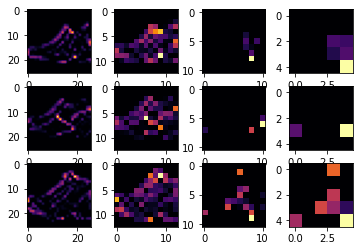

In [11]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)